## Duffing oscillator

In [25]:
# Imports
import jax.numpy as jnp
import jax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import equinox as eqx
jax.config.update('jax_enable_x64',True)
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

We consider the IVP

$$
u'' = \underbrace{- \alpha u - \beta u^3 -\delta u'}_{\mathcal{P}(u)} + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0 
$$

where $\alpha = -3$, $\beta = 3$, $\delta = 0.2$, $\gamma = 1$ and $\omega = 2$.


Equivalently, if we introduce the variables $x_0 = u$, and $x_1 = u'$ we can re-write the IVP as a system of two first-order ODEs

$$
\frac{d \mathbf{x}}{dt} =
\frac{d}{dt}
\begin{bmatrix}
x_0 \\
x_1
\end{bmatrix} =  
\begin{bmatrix}
x_1 \\
-\alpha x_0 - \beta x_0^3 - \delta x_1 + \gamma \cos(\omega t)
\end{bmatrix}\qquad x_0(0) = 0, x_1(0) = 0
$$


In [2]:
# Define the constants
alpha = -3.
beta = 3.
delta = 0.2
gamma = 1.
omega = 2

# Define forcing term
def forcing(t):
    return gamma*jnp.cos(omega*t)

# Define the Duffing RHS
@eqx.filter_jit
def duffing(t,x, args):
    return jnp.array([
        x[1],
        - alpha * x[0] - beta * x[0]**3 - delta * x[1] + forcing(t)
    ])

In [3]:
def show_term(c,neg = False):
    if neg is True:
        c = -c
    if c>0:
        return f"+{c}"
    elif c<0:
        return f"-{jnp.abs(c)}"
    else:
        return "0"
print(f"x''(t) = u(t) {show_term(beta,neg = True)} x(t)^3 {show_term(alpha,neg = True)} x(t) {show_term(delta,neg = True)} x'(t) \n u(t) = {gamma} cos({omega}t)")
print(f"")

x''(t) = u(t) -3.0 x(t)^3 +3.0 x(t) -0.2 x'(t) 
 u(t) = 1.0 cos(2t)



We use ```diffrax``` to solve numerically the ODE system

In [4]:
# Initial time
t0 = 0.
# Final time
t1 = 50.
# Define the RHS of the system
term = ODETerm(duffing)
# Pick a solver
solver = Dopri5()
# Save dense output, that can later be evaluated at any point inside [t0,t1]
saveat = SaveAt(dense=True)
# Size control: Adapts the step size to produce a solution accurate to a given tolerance
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)
# Initial condition
y0 = jnp.zeros(2)
# Solve
ode_sol = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 5000
    )

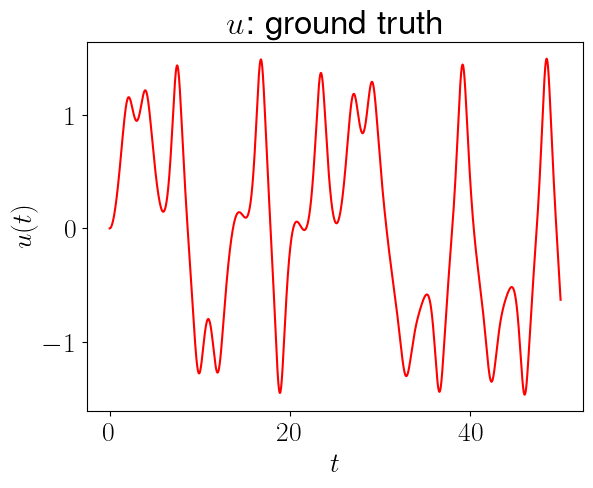

In [5]:
tvals = jnp.linspace(t0,t1,5000)
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.title('$u$: ground truth')
plt.plot(tvals,y_full[:,0], c = 'red')
plt.xlabel('$t$')
plt.ylabel('$u(t)$')
# plt.plot(tvals,y_full[:,1],label = "u'(t)")
plt.show()

# Get the data for the problem

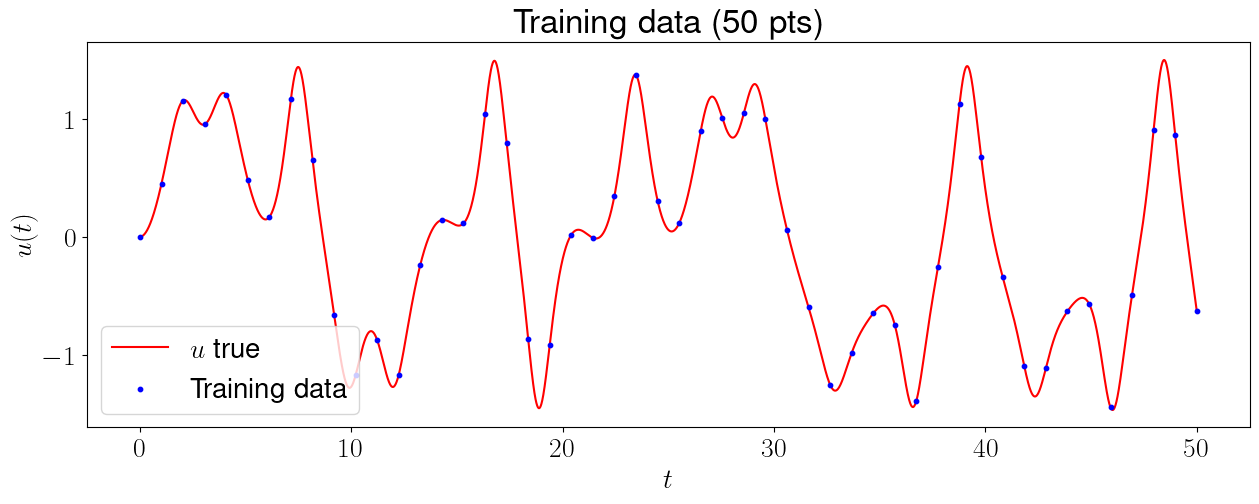

In [46]:
plt.figure(figsize=(15,5))
# X_dense
tvals = jnp.linspace(t0,t1,5000)
# u(X_dense)
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.plot(tvals,y_full[:,0], c = 'red', zorder=0, label = '$u$ true')
# X_obs
num_obs = 50
obs_times = jnp.linspace(t0,t1,num_obs)
# u(X_obs)
y_obs = jax.vmap(ode_sol.evaluate)(obs_times)[:,0]
plt.scatter(obs_times,y_obs, s=10,c= 'blue', zorder=1, label = 'Training data')
plt.title(f'Training data ({num_obs} pts)')
plt.ylabel('$u(t)$')
plt.xlabel('$t$')
plt.legend(loc = 'lower left')
plt.show()

In [26]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,jacrev
import numpy as np
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *

In [19]:
t_obs = obs_times.reshape(-1,1)

## Train the 1 step and 2 step method

In [20]:
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params,
    get_gaussianRBF,
    get_rq_kernel
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel,InducedOperatorModel
from functools import partial
from Kernels import log1pexp,inv_log1pexp

def dtt_k(k,index = 0):
    return dt_k(dt_k(k,index),index)

u_operators = (eval_k,dt_k,dtt_k)

feature_operators = (eval_k,dt_k)

k_u = get_rq_kernel(1.)
num_colloc = 1000
t_grid = jnp.linspace(t0,t1,num_colloc).reshape(-1,1)


u_model = CholInducedRKHS(
    t_grid,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(t_obs,y_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,t_grid,u_params_init))
    .reshape(
            len(t_grid),
            len(feature_operators),
            order = 'F'
        )
)
grid_features_init = jnp.hstack([t_grid,grid_features_init])

num_P_inducing = 500
P_inducing_points = jax.random.choice(jax.random.PRNGKey(13),grid_features_init,(num_P_inducing,))

k_P_u_part = get_gaussianRBF(1.)
def k_P(x,y):
    return k_P_u_part(x[1:],y[1:])
P_model = InducedOperatorModel(P_inducing_points,k_P)

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (t_obs,),
    (y_obs,),
    (t_grid,),
    feature_operators,
    rhs_operator=dtt_k,
    datafit_weight = 50,
    rhs_forcing_values = (-forcing(t_grid)[:,0],),
    num_P_operator_params = 500
)

utt_init = EqnModel.apply_rhs_op_single(u_model,u_params_init,EqnModel.collocation_points[0])-forcing(t_grid)[:,0]
P_params_init = P_model.get_fitted_params(grid_features_init,utt_init,lam = 1e-3)
params_init = jnp.hstack([u_params_init,P_params_init])

In [21]:
from Optimizers import CholeskyLM,LMParams

In [22]:
optParams = LMParams(max_iter = 1001,min_alpha = 1e-9)
sol,conv = CholeskyLM(params_init,EqnModel,1e-9,optParams = optParams)

  0%|          | 4/1001 [00:12<38:19,  2.31s/it]  

Iteration 0, loss = 0.1264, gradnorm = 0.3293, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.1105, gradnorm = 0.2359, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.09699, gradnorm = 0.1898, alpha = 1.736, improvement_ratio = 1.001
Iteration 3, loss = 0.0849, gradnorm = 0.1619, alpha = 1.447, improvement_ratio = 1.001
Iteration 4, loss = 0.07408, gradnorm = 0.1401, alpha = 1.206, improvement_ratio = 1.001
Iteration 5, loss = 0.06457, gradnorm = 0.1208, alpha = 1.005, improvement_ratio = 1.001


  5%|▌         | 55/1001 [00:13<00:36, 25.89it/s]

Iteration 50, loss = 0.008885, gradnorm = 0.001035, alpha = 0.0002747, improvement_ratio = 1.015


 11%|█         | 107/1001 [00:15<00:29, 30.75it/s]

Iteration 100, loss = 1.694e-06, gradnorm = 1.207e-05, alpha = 3.019e-08, improvement_ratio = 0.9967


 12%|█▏        | 121/1001 [00:15<01:56,  7.57it/s]


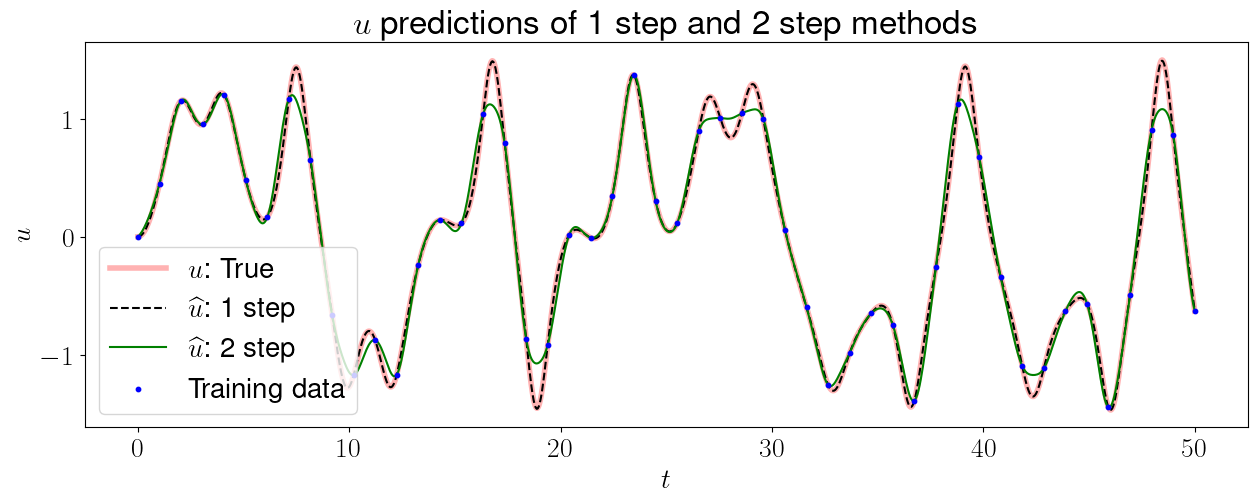

In [81]:
# u predictions
plt.figure(figsize=(15,5))
# u true
plt.plot(tvals,y_full[:,0],label = '$u$: True', c = 'red', lw = 4, alpha= 0.3, zorder=0)
# 1 step u pred
plt.plot(t_grid,u_model.point_evaluate(t_grid,EqnModel.get_u_params(sol)[0]),c = 'black',ls ='dashed',label = r'$\widehat{u}$: 1 step', zorder=1)
# 2 step u pred
plt.plot(t_grid,u_model.point_evaluate(t_grid,u_params_init),label = r'$\widehat{u}$: 2 step', c= 'green', zorder=2)
# Training data
plt.scatter(obs_times,y_obs, s=10,c= 'blue', zorder=3, label='Training data')
# Plot configs
plt.title('$u$ predictions of 1 step and 2 step methods')
plt.xlabel('$t$')
plt.ylabel('$u$')
plt.legend(loc = 'lower left')
plt.show()

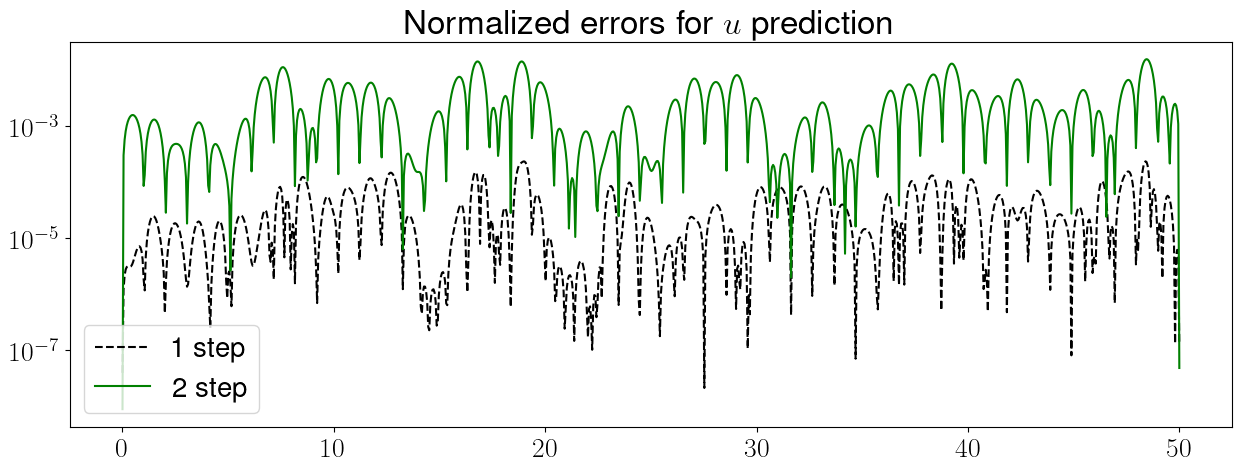

In [82]:
# u errors
plt.figure(figsize=(15,5))
true = jax.vmap(ode_sol.evaluate)(t_grid[:,0])[:,0]
# 1 step method
pred_1_step = u_model.point_evaluate(t_grid,EqnModel.get_u_params(sol)[0])
plt.plot(t_grid,jnp.abs(pred_1_step- true)/jnp.linalg.norm(true),label = '1 step',c = 'black',ls ='dashed')
# 2 step method
pred_2_step = u_model.point_evaluate(t_grid,u_params_init)
plt.plot(t_grid,jnp.abs(pred_2_step- true)/jnp.linalg.norm(true),label = '2 step', c= 'green')
# Plot configs
plt.title('Normalized errors for $u$ prediction')
plt.yscale('log')
plt.legend()
plt.show()

## How well perform $\widehat{P}$ learned from 1 step and 2 step methods ?

Let's compute the simulated trajectories starting at a different initial condition from:

1. $u'' = \underbrace{- \alpha u - \beta u^3 -\delta u'}_{\mathcal{P}(u)} + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

2. $u'' = \widehat{P}_{1step}(u) + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

3. $u'' = \widehat{P}_{2step}(u) + \gamma \cos (\omega t) \qquad u(0) = 0,u'(0) = 0.5$.

In [83]:
# Learned parameters for 1-step
fitted_P_params = EqnModel.get_P_params(sol)
# Phat 1-step method
def learned_vf(t,x,args):
    input = jnp.hstack([t,x]).reshape(1,-1)
    return jnp.array([x[1],P_model.predict(input,fitted_P_params)[0] + forcing(t)])
# Phat 2-step method
def init_vf(t,x,args):
    input = jnp.hstack([t,x]).reshape(1,-1)
    return jnp.array([x[1],P_model.predict(input,P_params_init)[0] + forcing(t)])

In [84]:
# New initial condition
new_initcon = jnp.array([-0.3,0.5])

In [85]:
y0 = jnp.array([0.,0.5])
term = ODETerm(duffing)
fitted_term = ODETerm(learned_vf)
init_term = ODETerm(init_vf)

ode_truth = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=0, t1=26, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_fitted = diffeqsolve(
    terms = fitted_term, 
    solver = solver, 
    t0=0, t1=26, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_init = diffeqsolve(
    terms = init_term, 
    solver = solver, 
    t0=0, t1=26, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

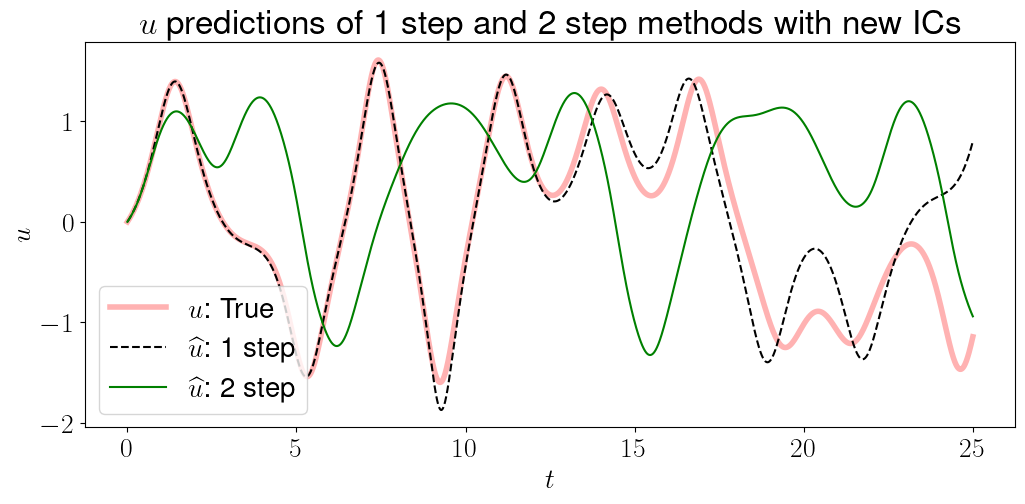

In [94]:
# u predictions
plt.figure(figsize=(12,5))
tvals = jnp.linspace(0,25,5000)
# u true
plt.plot(tvals,jax.vmap(ode_truth.evaluate)(tvals)[:,0], label = '$u$: True', c = 'red', lw = 4, alpha= 0.3, zorder=0)
# u pred 1-step
plt.plot(tvals,jax.vmap(ode_fitted.evaluate)(tvals)[:,0], c = 'black',ls ='dashed',label = r'$\widehat{u}$: 1 step', zorder=1)
# u pred 2-step
plt.plot(tvals,jax.vmap(ode_init.evaluate)(tvals)[:,0],label = r'$\widehat{u}$: 2 step', c= 'green', zorder=2)
# Plt configs
plt.title('$u$ predictions of 1 step and 2 step methods with new ICs')
plt.xlabel('$t$')
plt.ylabel('$u$')
plt.legend(loc = 'lower left')
plt.show()

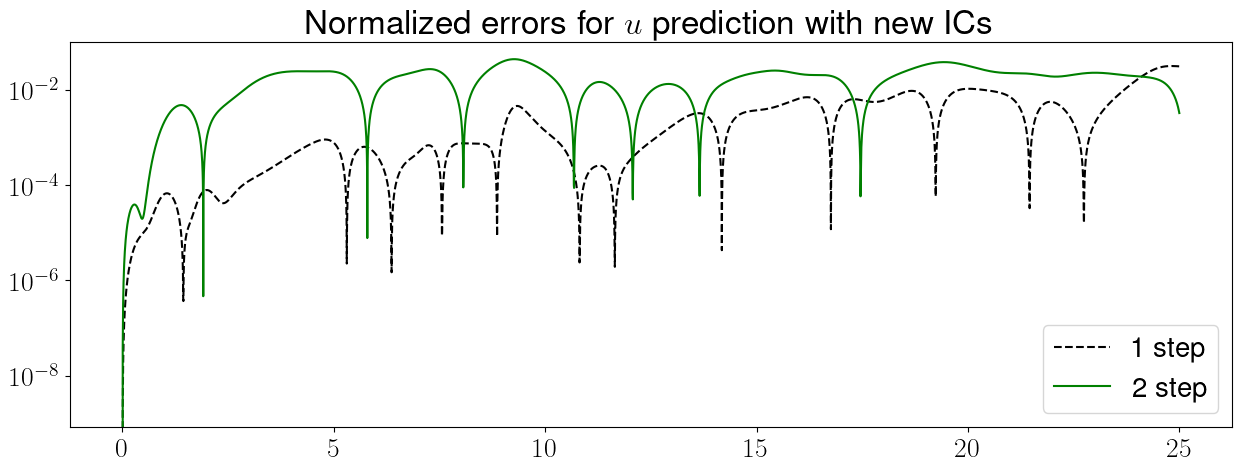

In [93]:
# u errors
plt.figure(figsize=(15,5))
true = jax.vmap(ode_truth.evaluate)(tvals)[:,0]
# 1 step method
pred_1_step = jax.vmap(ode_fitted.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_1_step- true)/jnp.linalg.norm(true),label = '1 step',c = 'black',ls ='dashed')
# 2 step method
pred_2_step = jax.vmap(ode_init.evaluate)(tvals)[:,0]
plt.plot(tvals,jnp.abs(pred_2_step- true)/jnp.linalg.norm(true),label = '2 step', c= 'green')
# Plot configs
plt.title('Normalized errors for $u$ prediction with new ICs')
plt.yscale('log')
plt.legend()
plt.show()

## SINDy

In [181]:
import numpy as np
import pysindy as ps
from pysindy import SINDy
from pysindy.utils import lorenz
from scipy.integrate import solve_ivp

diff = ps.FiniteDifference(order = 2,drop_endpoints=True)
# diff = ps.SpectralDerivative()
sindy_t = np.array(t_obs[:,0])

dt = sindy_t[1]-sindy_t[0]

ydot = diff(y_obs,t = dt)[1:-1]

#Drop endpoints
X = np.vstack([y_obs[1:-1],ydot]).T
t_vals = sindy_t[1:-1]

model = SINDy(
    optimizer=ps.STLSQ(threshold =0.2,alpha = 0.2),
    differentiation_method = diff,
    feature_library = ps.PolynomialLibrary(degree=3)
)
model.fit(X, t=dt,u = forcing(t_vals))
model.print()


(x0)' = 1.000 x1
(x1)' = 0.265 u0 + -0.261 x0^3 + -0.783 x0 x1^2 + -0.374 u0^3


In [ ]:
# do the SINDy with the derivatives using the kernel interpolant.